# Impoting Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Colour

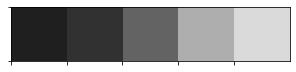

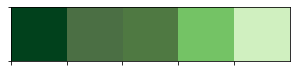

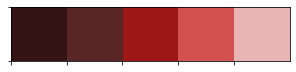

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

# Data Preparation

In [4]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

# Dataset Loading

In [5]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/home/sysadm/Downloads/cleaned','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_test = []
y_test = []
for i in labels:
    folderPath = os.path.join('/home/sysadm/Downloads/cleaned','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 74/74 [00:00<00:00, 1430.56it/s]


# Sample image from each labels

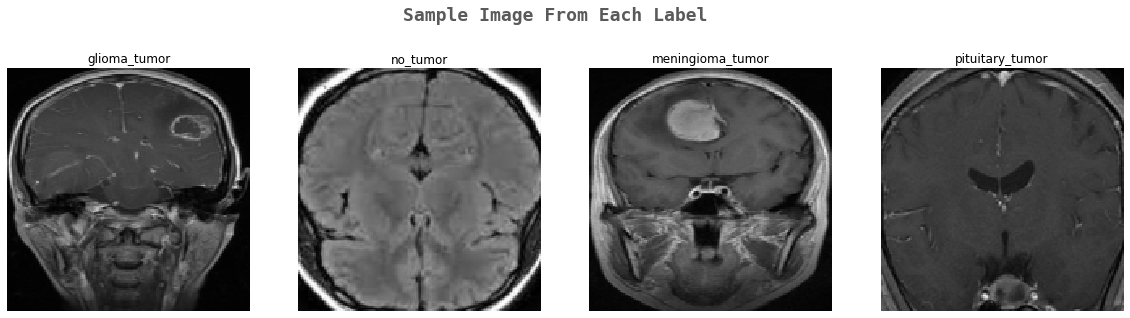

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(4345, 150, 150, 3)

# One-hot Encoding

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Model fit

In [10]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [11]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024, activation="relu")(model)
model = tf.keras.layers.Dense(1024, activation="relu")(model)
model = tf.keras.layers.Dense(512, activation="relu")(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
predictions = tf.keras.layers.Dense(4, activation="sigmoid")(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = predictions)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

# Model Compilation

In [13]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

# Training the model

In [15]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

/home/sysadm/anaconda3/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/12
123/123 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.8563
Epoch 00001: val_accuracy improved from -inf to 0.91034, saving model to effnet.h5
123/123 [==============================] - 226s 2s/step - loss: 0.4167 - accuracy: 0.8563 - val_loss: 0.3729 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 2/12
123/123 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9299
Epoch 00002: val_accuracy improved from 0.91034 to 0.95402, saving model to effnet.h5
123/123 [==============================] - 207s 2s/step - loss: 0.2306 - accuracy: 0.9299 - val_loss: 0.1583 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 3/12
123/123 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9517
Epoch 00003: val_accuracy did not improve from 0.95402
123/123 [==============================] - 201s 2s/step - loss: 0.1652 - accuracy: 0.9517 - val_loss: 0.3299 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 4/12
123/123 [==============================] -

# Plot between Epochs vs Training and Validation Accuracy and Loss

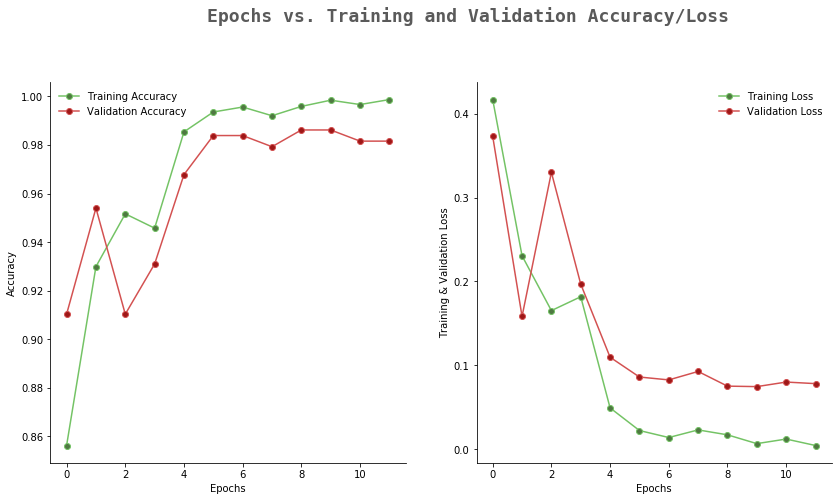

In [21]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

# Testing Accuarcy

In [22]:
scores = model.evaluate(X_test,y_test)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

25/25 [==============================] - 8s 325ms/step - loss: 0.8396 - accuracy: 0.8974
evaluate accuracy: 89.74%


# Prediction

In [23]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


In [24]:
print(classification_report(y_test_new,pred))


              precision    recall  f1-score   support

           0       1.00      0.31      0.47       100
           1       0.93      1.00      0.96       510
           2       0.72      1.00      0.84       115
           3       1.00      0.82      0.90        74

    accuracy                           0.90       799
   macro avg       0.91      0.78      0.79       799
weighted avg       0.92      0.90      0.88       799



# Confusion Matrix with Heatmap

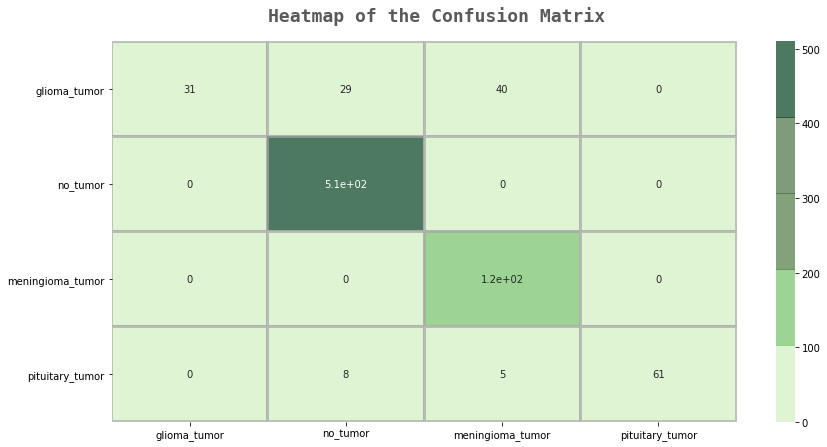

In [25]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()